In [1]:
!pip install fairsearchcore tqdm

  Created wheel for fairsearchcore: filename=fairsearchcore-1.0.4-py3-none-any.whl size=10832 sha256=c0bcb0cb4fc94d4a1fdd0de46cafe0fbd0d56f87c511de7c11348679c760eb54
  Stored in directory: /root/.cache/pip/wheels/dd/d0/42/afb7cd10d9b0276f110d53cd68f7d93b7c91d672e668927804
Successfully built fairsearchcore


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fairsearchcore as fsc
from fairsearchcore.models import FairScoreDoc
%matplotlib inline
from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv('processed_data.csv')
df

gender  n_usa  citations
0           0      1  12.237111
1           0      0  11.188455
2           0      1  11.364402
3           0      1  11.534667
4           0      0  11.946285
...       ...    ...        ...
80205       0      1   6.424869
80206       0      1   5.257495
80207       0      1   5.598422
80208       0      1   5.036953
80209       0      1   8.488588

[80210 rows x 3 columns]

In [4]:
def sample_size(population, size):
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

def sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = sample_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"

            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)

        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)

    return stratified_df.sample(frac=1).reset_index(drop=True)

In [5]:
def df_to_operating_tuple(df):
    return [(item['citations'], (int(item['gender']), int(item['n_usa']))) for index, item in df.iterrows()]

In [6]:
df

gender  n_usa  citations
0           0      1  12.237111
1           0      0  11.188455
2           0      1  11.364402
3           0      1  11.534667
4           0      0  11.946285
...       ...    ...        ...
80205       0      1   6.424869
80206       0      1   5.257495
80207       0      1   5.598422
80208       0      1   5.036953
80209       0      1   8.488588

[80210 rows x 3 columns]

In [7]:
def df_to_tup(df):
    q = [x for x in df['citations']]
    a = [(x[1]['gender'], x[1]['n_usa']) for x in df[['gender', 'n_usa']].iterrows()]
    return a, q

In [8]:
# return individuals with top percieved qualities
def getTop(a, q, top=0.1):
    top = int(len(q) * top)
    ordered = [i for i in sorted(zip(q, a), reverse=True)]
    return ordered[:top]

In [16]:
# return individuals top individuals after debiasing
def getTopDebiasedRanked(a, q, top=0.1):
    # Debiasing is always on the visible (first) attribute
    #     Allocate proportional quotas
    quota_1 = int(len([x for x in a if x[0] == 1]) * top)
    quota_0 = int(len([x for x in a if x[0] == 0]) * top)

    ordered = [i for i in sorted(zip(q, a), reverse=True)]

    return [x for x in ordered if x[1][0] == 0][:quota_0] + [x for x in ordered if x[1][0] == 1][:quota_1]


# return individuals top individuals after debiasing
def getTopDebiased(a, q, top=0.1):
    quota_list = getTopDebiasedRanked(a, q, top)

    quota_1 = len([x for x in quota_list if x[1][0] == 1]) / len(quota_list)

    sorted_items = sorted(quota_list, reverse=True)
    ordered = [FairScoreDoc(index, item[0], item[1][0] == 1) for index, item in enumerate(sorted_items)]

    fair = fsc.Fair(len(quota_list), quota_1, 0.1)

    # now re-rank the unfair ranking
    re_ranked = fair.re_rank(ordered)

    return [(item.score, (sorted_items[item.id][1])) for item in re_ranked]

In [10]:
def get_aggregated(data, N, Nsim, k_range):
    results = {'original': {0: [], 1: []},
               'debiased': {0: [], 1: []}}

    groups = [0, 1]

    for k in k_range:
        simulations = {'original': {0: [], 1: []},
                       'debiased': {0: [], 1: []}}
        for i in tqdm(range(0, Nsim), desc='Simulations for top {}'.format(k*100)):
            # properties, perceived qualities and real qualities
            df_samp = sample(data, ['gender', 'n_usa'], N)
            a, q = df_to_tup(df_samp)

            for group in groups:
                # compute expected chances to be in top
                exp = len([x for x in a if x[0] == group]) / len(q)
                for approach in ['original', 'debiased']:
                    if approach == 'original':
                        top = getTop(a, q, k)
                    else:
                        top = getTopDebiased(a, q, k)
                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)
                    simulations[approach][group].append((real - exp) / exp)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
    return results

In [11]:
def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}

    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [21]:
# for quick results
Nsim = 10
print('Number of Simulations : ', Nsim)

# to fetch top k% candidates
k_range = [i / 100 for i in range(1, 101, 5)]
print('Ranking Indexes : ', k_range)

Number of Simulations :  10
Ranking Indexes :  [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]


Simulations for top 1.0:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairsearchcore/fair.py:165: UserWarning: Library has not been tested with values outside this range
  warnings.warn("Library has not been tested with values outside this range")
/usr/local/lib/python3.7/dist-packages/fairsearchcore/fair.py:172: UserWarning: Library has not been tested with values outside this range
  warnings.warn("Library has not been tested with values outside this range")


Simulations for top 6.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 11.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 16.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 21.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 26.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 31.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 36.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 41.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 46.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 51.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 56.00000000000001:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 61.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 66.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 71.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 76.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 81.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 86.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 91.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for top 96.0:   0%|          | 0/10 [00:00<?, ?it/s]

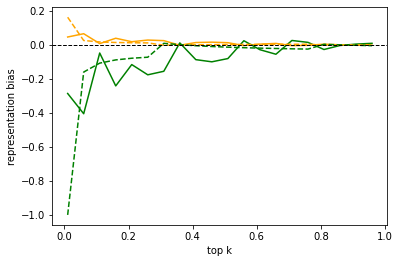

In [22]:
results_agg = get_aggregated(df, 300, Nsim, k_range)
plot_aggregated(results_agg)

In [23]:
def get_disaggregated(data, N, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]

    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}

        for i in tqdm(range(0, Nsim), desc='Simulations for Top {}'.format(k*100)):
            df_samp = sample(data, ['gender', 'n_usa'], N)
            a, q = df_to_tup(df_samp)

            for g in groups:

                # compute expected chances to be in top
                exp = len([x for x in a if x == g]) / len(q)

                for approach in ['original', 'debiased']:

                    if approach == 'original':
                        top = getTop(a, q, k)
                    else:
                        top = getTopDebiased(a, q, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

In [24]:
def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    for g in groups:
        for approach in ['original', 'debiased']:
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.fill_between(k_range, results['debiased'][(0,1)], results['original'][(0,1)], color='orange', alpha=.25)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

Simulations for Top 1.0:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairsearchcore/fair.py:165: UserWarning: Library has not been tested with values outside this range
  warnings.warn("Library has not been tested with values outside this range")
/usr/local/lib/python3.7/dist-packages/fairsearchcore/fair.py:172: UserWarning: Library has not been tested with values outside this range
  warnings.warn("Library has not been tested with values outside this range")


Simulations for Top 6.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 11.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 16.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 21.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 26.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 31.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 36.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 41.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 46.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 51.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 56.00000000000001:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 61.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 66.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 71.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 76.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 81.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 86.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 91.0:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations for Top 96.0:   0%|          | 0/10 [00:00<?, ?it/s]

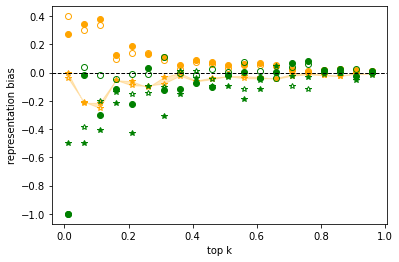

In [25]:
results_dis_agg = get_disaggregated(df, 300, Nsim, k_range)
plot_disaggregated(results_dis_agg)

In [27]:
np.save('results_fair_citations.npy', {'agg': results_agg, 'diss_agg': results_dis_agg})

In [28]:
read_dictionary = np.load('results_fair_citations.npy', allow_pickle='TRUE').item()
read_dictionary

{'agg': {'debiased': {0: [0.16279069767441862,
    0.02599179206566346,
    0.0174418604651163,
    0.014349332013854585,
    0.01275318829707429,
    0.011778918755662907,
    -0.001516683518705703,
    -0.00021734405564008088,
    0.0007624857033930261,
    0.0015277542013240081,
    0.002141982864137055,
    0.0026458710486005174,
    0.003066700741119412,
    0.0034234446936607784,
    0.0037297060114084993,
    0.003995492265136841,
    -0.000576590428598842,
    -9.048954845707543e-05,
    0.0003419972640219641,
    0.0007292763957540468],
   1: [-1.0,
    -0.1596638655462186,
    -0.10714285714285723,
    -0.08814589665653513,
    -0.07834101382488491,
    -0.07235621521335825,
    0.00931677018633523,
    0.0013351134846460127,
    -0.0046838407494146994,
    -0.009384775808133588,
    -0.013157894736842105,
    -0.01625320786997441,
    -0.018838304552590276,
    -0.0210297316896303,
    -0.02291105121293812,
    -0.024543738200125908,
    0.003541912632821656,
    0.000555864